In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import keras.metrics
import keras.regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
df = pd.read_csv('BestFeatures.csv', header=0, sep=',',decimal='.', skip_blank_lines=True, parse_dates=['Date'])

df.head()

In [ ]:
df.set_index('Date', inplace=True)
df = df.drop('Year', axis=1)
cols = list(df.columns.values) 
cols.pop(cols.index('SE3'))
df = df[cols+['SE3']]

In [ ]:
#tmp = df
#dif = []
#for i in range(1, len(tmp)):
#  value = tmp.iloc[i][-1] - tmp.iloc[i - 1][-1]
#  dif.append(value)


In [ ]:
#for i, row in enumerate(dif):
#  df.iat[i, -1] = row

In [ ]:
#tmp = dif
#diff = []
#for i in range(1, len(tmp)):
#  value = tmp[i] + tmp[i - 1]
#  diff.append(value)

In [ ]:
#plt.plot(diff)
#plt.show()

In [ ]:
train = df[:-18888] # 2017-03-03 -- 2020-05-26
test = df[-9456:] # Test: 2021-06-23 -- 2022-07-21

In [ ]:
train

In [ ]:
test

In [ ]:
n_inputs = 24
n_features = train.shape[1]

vali_train_x = df[-18888:-9456] # validation: 2020-05-26 -- 2021-06-23
train_x = train

vali_train_y = df['SE3'][-18888:-9456]
train_y = train['SE3']

In [ ]:
vali_train_x

In [ ]:
generator_train = TimeseriesGenerator(train_x, train_y, length=n_inputs, batch_size=40)
generator_vali = TimeseriesGenerator(vali_train_x, vali_train_y, length=n_inputs, batch_size=40)
generator_test  = TimeseriesGenerator(test, test['SE3'], length=n_inputs, batch_size=40)

In [ ]:
sc =  StandardScaler()
sc_y = StandardScaler()

sc.fit(generator_train.data)
sc_y.fit(generator_train.targets.to_numpy().reshape(-1, 1))

generator_train.data = sc.transform(generator_train.data)
generator_train.targets = sc_y.transform(generator_train.targets.to_numpy().reshape(-1, 1))

generator_vali.data = sc.transform(generator_vali.data)
generator_vali.targets = sc_y.transform(generator_vali.targets.to_numpy().reshape(-1, 1))

generator_test.data = sc.transform(generator_test.data)
generator_test.targets = sc_y.transform(generator_test.targets.to_numpy().reshape(-1, 1))

In [ ]:
x,y = generator_train[0]
tasd = sc_y.inverse_transform(y)

In [ ]:
tasd[0]

In [ ]:
x.shape

In [ ]:

regressor = Sequential()
#regressor.add(LSTM(units = 80, return_sequences=True,  input_shape = (n_inputs, n_features), dropout=0.20))
#regressor.add(Dense(units = 40))
#regressor.add(LSTM(units = 80, kernel_regularizer=keras.regularizers.L1(), dropout=0.20))
#regressor.add(Dense(units = 40))
#regressor.add(LSTM(units = 100,  return_sequences = True, input_shape = (n_inputs, n_features), dropout=0.20))
#regressor.add(LSTM(units = 60, return_sequences = True, dropout=0.20))
#regressor.add(LSTM(units = 50, dropout=0.20))

regressor.add(LSTM(units = 150, activation="relu", kernel_regularizer=keras.regularizers.L1(), return_sequences=True,  input_shape = (n_inputs, n_features), dropout=0.20))
#regressor.add(Dense(units = 40, activation="relu"))
#regressor.add(LSTM(units = 80, kernel_regularizer=keras.regularizers.L1(), dropout=0.20))
#regressor.add(Dense(units = 40, activation="sigmoid"))

regressor.add(Dense(units = 1))

regressor.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss="mse",metrics=[keras.metrics.RootMeanSquaredError(name="RMSE"), keras.metrics.MeanAbsoluteError(name="MAE"), keras.metrics.MeanAbsolutePercentageError(name="MAPE")])


In [ ]:
#regressor = keras.models.load_model('E:\Vs Skola\WebSemantic\Machine Learning\EnergyProject\\2023-3-12 T 22-34')

In [ ]:
regressor.fit(generator_train, validation_data=generator_vali, shuffle=False, epochs = 200)

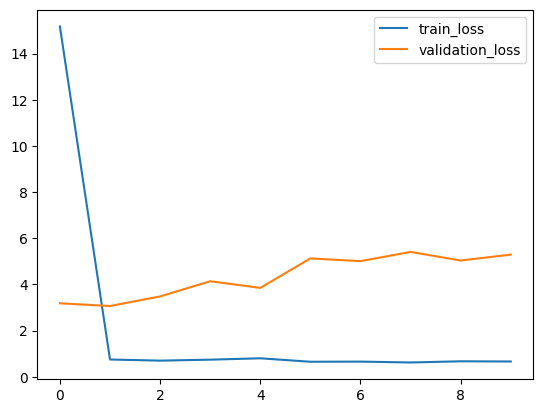

In [69]:
loss_e = regressor.history.history['loss']
val_loss = regressor.history.history['val_loss']

plt.plot(range(len(loss_e)), loss_e, label="train_loss")
plt.plot(range(len(val_loss)), val_loss, label="validation_loss")
plt.legend()
plt.show()

In [70]:
pred =  regressor.predict(generator_test)

re_yhat = sc_y.inverse_transform(pred)
re_y = sc_y.inverse_transform(generator_test.targets)

236/236 [==============================] - 6s 22ms/step


In [71]:
sa = re_y
sa = sa[:-n_inputs]

In [72]:
sa.shape

(9432, 1)

Test Score: 97.32 RMSE
Test Score: 3552562.00 MAPE
Test Score: 67.72 MAE


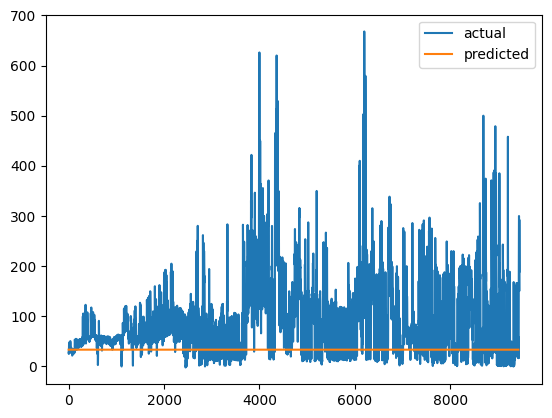

In [73]:
rmse = np.sqrt(keras.metrics.mean_squared_error(sa[:,0], re_yhat[:,0]))
mape = keras.metrics.mean_absolute_percentage_error(sa[:,0], re_yhat[:,0])
mae = keras.metrics.mean_absolute_error(sa[:,0], re_yhat[:,0])
#
print('Test Score: %.2f RMSE' % (rmse))
print('Test Score: %.2f MAPE' % (mape))
print('Test Score: %.2f MAE' % (mae))


plt.plot(re_y, label="actual")
plt.plot(re_yhat, label="predicted")
plt.legend()
plt.show()

In [74]:
#import datetime
#import os
#now = datetime.datetime.now()
#path = "E:\Vs Skola\WebSemantic\Machine Learning\EnergyProject"+ "\\" + str(now.year) + "-" + str(now.month) + "-" + str(now.day)+ " T " + str(now.hour) + "-" + str(now.minute)
#os.makedirs(path)
#regressor.save(path)
#model = keras.models.load_model('E:\Vs Skola\WebSemantic\Machine Learning\EnergyProject\\2023-3-10 T 17-43')
#model.get_config()